# Self-Organizing Maps (SOMs) Notebook
## Finding "winning" SOMs - Step 3

**Notebook by Maria J. Molina (NCAR) and Alice DuVivier (NCAR).**

**Still very much in progress**

This Notebook reads in the CSV file output by the training step to find the winning SOMs.

In [1]:
import pandas as pd
from minisom import MiniSom, asymptotic_decay
import xarray as xr
import cftime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from datetime import timedelta
from itertools import product
import seaborn as sns
import pickle
import sammon

### Set User-specified information

In [2]:
# set: variable to test, the location of the already extracted training data
var_in = 'aice_d_hi_d'
sector_short = 'Ross'
data_path = '/glade/p/cgd/ppc/duvivier/cesm2_antarctic_polynya/SOM_analysis/training/'+sector_short+'_v5/'

In [3]:
# set possible grid sizes. These are paired values.
som_grid_rows    = [3, 4, 5]    # (y-axis)
som_grid_cols    = [3, 4, 5]    # (x-axis)

In [4]:
# MANUAL CHANGING REQUIRED HERE
n = 0
# n = 0-2 (matches sizes set above)

som_row = som_grid_rows[n]
som_col = som_grid_cols[n]

## Load training data


In [5]:
# open file saved in earlier notebook (soms_antarctica-gettingdata.ipynb)
subset = xr.open_dataset(data_path+'training_data_region_'+sector_short+'_'+var_in+'.nc')

# assign to numpy array object
subsetarray = subset['train_data'].values

In [6]:
# check the data dims/shape - should match the dims from the getting data notebook
print(subsetarray.shape)
# confirm there are no NaN values in array for training (should print False if no values)
print(np.isnan(subsetarray).any())

(232300, 378)
False


## Load CSV with winning combos

In [7]:
# read in the file with all the possible soms
df = pd.read_csv(data_path+'test_soms_qerror_'+sector_short+'_'+var_in+'_'+str(som_row)+'x'+str(som_col)+'.csv')

In [8]:
# sort values by q_error
sorted_df = df.sort_values(['q_error'])

# find and save the lowest qerror for top # (10)
top_n = sorted_df.head(20)
bottom_n = sorted_df.tail(20)
#print(top_n)

In [9]:
# grab the qerrors and make array against which to plot
qerr_all = sorted_df.q_error
xarr_all = np.arange(1,len(qerr_all)+1,1)
qerr_n = top_n.q_error
xarr_n = np.arange(1,len(qerr_n)+1,1)

Plotting qerror for som: 3x3


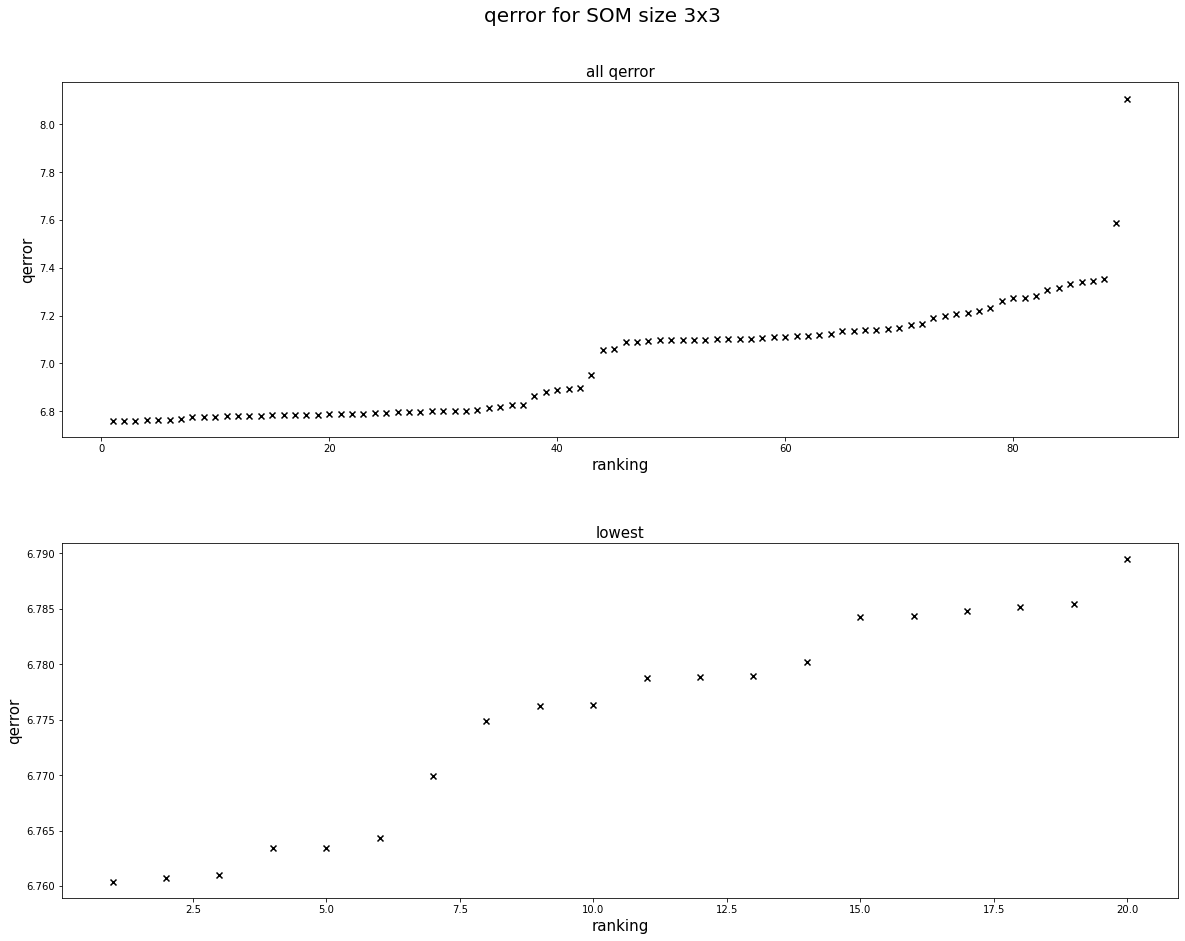

In [10]:
print('Plotting qerror for som: '+str(som_row)+'x'+str(som_col))

# set output name
fout = data_path+'som_evaluation/qerror_plot_'+sector_short+'_'+var_in+'_'+str(som_row)+'x'+str(som_col)+'.png'
label_in = 'qerror for SOM size '+str(som_row)+'x'+str(som_col)

# Actually plot figure now
fig = plt.figure(figsize=(20,15))

# plot all SOM qerror
ax = fig.add_subplot(2,1,1)
ax.scatter(xarr_all,qerr_all,marker='x',c='black')
plt.title('all qerror',fontsize=15)
plt.xlabel('ranking',fontsize=15)
plt.ylabel('qerror',fontsize=15)

# plot lowest n SOM qerror
ax = fig.add_subplot(2,1,2)
ax.scatter(xarr_n,qerr_n,marker='x',c='black')
plt.title('lowest',fontsize=15)
plt.xlabel('ranking',fontsize=15)
plt.ylabel('qerror',fontsize=15)

# Finalize figure and save
fig.suptitle(label_in,fontsize=20, y=0.95)  
fig.subplots_adjust(hspace=0.3)

# save figure:
fig = plt.savefig(fout, bbox_inches='tight', dpi=200)

## SOM training for winning combos

In [ ]:
def normalize_data(data):
    """
    Function for normalizing data prior to training using z-score
    """
    return (data - np.nanmean(data)) / np.nanstd(data)

In [ ]:
# SOM hyperparameters - common to all
input_length = subsetarray.shape[1]    # using preprocessed data array; Number of the elements of the vectors in input.
decay_function = asymptotic_decay
neighborhood_function = 'gaussian'
topology = 'rectangular'                 # Topology of the map; Possible values: 'rectangular', 'hexagonal'
activation_distance = 'euclidean'        # Distance used to activate the map; Possible values: 'euclidean', 'cosine', 'manhattan', 'chebyshev'
random_seed = 1                          # Random seed to use for reproducibility. Using 1.
data = normalize_data(subsetarray)
random_order = True
verbose = True

In [ ]:
# Loop through the lowest values, retrain SOM and save as pickles

for n in xarr_n:
    print(str(n)+'th lowest qerror')
    
    # set the training values
    qerr = top_n.iloc[n-1]['q_error'].item()
    sig = top_n.iloc[n-1]['sigma'].item()
    lr = top_n.iloc[n-1]['lr'].item()
    n_iter = int(top_n.iloc[n-1]['n_iter'].item())
    
    print('original qerr = '+str(qerr))
    # initialization of SOM
    som = MiniSom(
            som_row,
            som_col,
            input_length,
            sig,
            lr,
            decay_function,
            neighborhood_function,
            topology,
            activation_distance,
            random_seed) 
    # before training, initialize the data
    som.pca_weights_init(data) 
    # actually train SOM - the quantization error here should match qerr printed above
    som.train(
        data,
        n_iter,
        random_order,
        verbose)
    
    # save the som as a pickle to analyze later
    fout = 'som_'+sector_short+'_'+var_in+'_'+str(som_row)+'x'+str(som_col)+'_rank_'+str(n)+'_sig'+str(sig)+'_lr'+str(lr)+'_iter'+str(n_iter)
    with open(data_path+'pickles/'+fout+'.p', 'wb') as outfile:
        pickle.dump(som, outfile)
    

## Plot Sammon maps

In [ ]:
# Loop through the lowest values and load in the relevant pickle

for n in xarr_n:
    print(str(n)+'th lowest qerror')
    
    # set the training values
    qerr = top_n.iloc[n-1]['q_error'].item()
    sig = top_n.iloc[n-1]['sigma'].item()
    lr = top_n.iloc[n-1]['lr'].item()
    n_iter = int(top_n.iloc[n-1]['n_iter'].item())
    
    # construct the input name from this, set as output for figure names
    fin = 'som_'+sector_short+'_'+var_in+'_'+str(som_row)+'x'+str(som_col)+'_rank_'+str(n)+'_sig'+str(sig)+'_lr'+str(lr)+'_iter'+str(n_iter)

    # open pickle
    with open(data_path+'/pickles/'+fin+'.p', 'rb') as infile:
        som = pickle.load(infile)

    # Calculate sammon coordinates (y) for map and "map stress" (E)
    [y,E] = sammon.sammon(som.get_weights().reshape(som_col*som_row, input_length),2,display=1)

    # Plot Sammon map nodes
    fig = plt.figure(figsize=(10,8))
    plt.scatter(y[:,0], y[:,1], s=20, c='black', marker='o')

    # Add lines between nodes
    tmp = np.reshape(y,(som_col,som_row,2))
    len_x, len_y, len_z = tmp.shape
    
    # add vertical lines
    for i in range(len_x-1):
        for j in range(len_y):
            plt.plot(tmp[i:i+2,j,0],tmp[i:i+2,j,1],c='black')
    
    # add horizontal lines
    for i in range(len_x):
        for j in range(len_y-1):
            plt.plot(tmp[i,j:j+2,0],tmp[i,j:j+2,1],c='black')  
    
    plt.xticks([])
    plt.yticks([])
    plt.title(r"sammon map" "\n" r"map stress = "+str(E), fontsize=12)
    
    # save figure
    fout = data_path+'som_evaluation/'+fin+'_sammon.png'
    plt.savefig(fout, bbox_inches='tight', dpi=200)
